In [39]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm, trange
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from Scripts.misc import mape, mse, rmse, me
from Scripts.constants import utd
from Scripts.datasets import UTDCityDataset, train_val_test_split

from functools import partial

In [21]:
import warnings
warnings.filterwarnings("ignore")

# Time Series Forecasting Hourly Traffic Flow
The ability to forecast traffic is an important task for navigation systems, scheduling rides in ride sharing apps, and transportation of goods. While it is possible to predict traffic flow using a series of exogenous regressors (e.g. time of day, intersection, etc.), it makes more intuitive sense to predict the flow of traffic based on the current (or past states). For example, if my friend and I were going from his house to the lake and he left ten minutes before me and encountered 20 minutes of traffic, I could expect it to take about 20 minutes for me to get to the lake. Similarly, if my commute to work on monday took 30 minutes, it would be fair to assume that my commute next week could also take 30 minutes.

To build up are intuition and understanding of traffic patterns, lets look at the traffic flow at one detector in paris:

In [28]:
dfs = utd.get_city_dfs('paris', True, False, False)
df_traffic = dfs.traffic_df

In [43]:
df_traffic = df_traffic.loc[df_traffic.detid == 1949][['day', 'interval', 'flow']]
flow = df_traffic.flow
flow_diff = flow.diff()

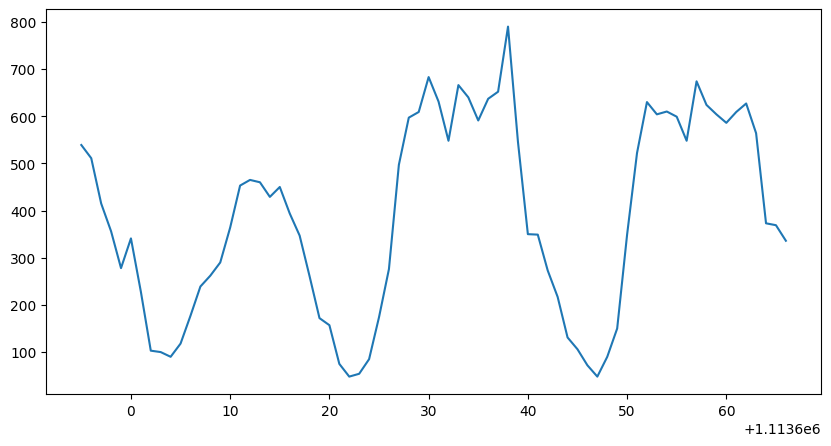

In [48]:
f, ax = plt.subplots(figsize=(10, 5))
tmp = df_traffic.iloc[:72]
ax.plot(tmp.flow)

The above graph is the flow of traffic (number of cars through intersection per hour). We can see that there is strong seasonality in the data that repeats every 24 hours: morning rush hour, evening rush hour, quiet. However, the pattern isn't that simple because traffic isn't as bad on weekends or holidays. Furthermore, the traffic also depends on season, etc.

Now lets perform a seasonal decomposition on the data.

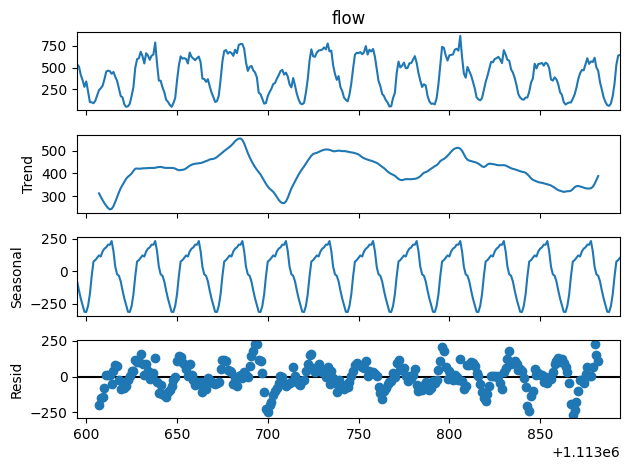

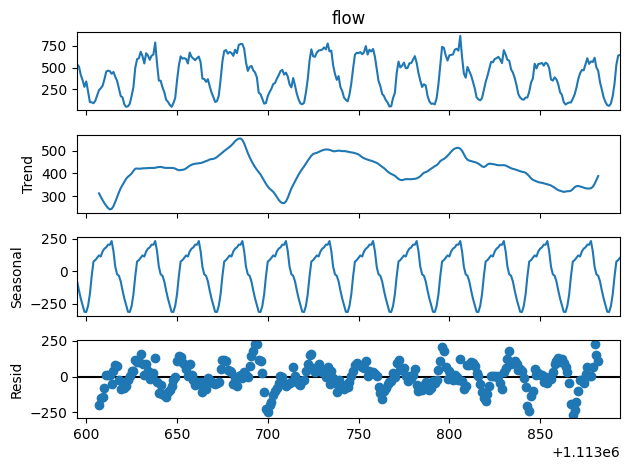

In [18]:
decomp = seasonal_decompose(flow.iloc[:300], model='additive', period=24)
# Plot the decomposition
decomp.plot()

In [26]:
from Scripts.auto_regression import partial_arma
train_flow = flow_diff.iloc[:7500]
test_flow = flow_diff.iloc[7500:]

arma = partial_arma((4, 4))
arma = arma(train_flow)
fitted_arma = arma.fit()
fitted_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   flow   No. Observations:                 7500
Model:                 ARIMA(4, 0, 4)   Log Likelihood              -43233.817
Date:                Mon, 24 Jun 2024   AIC                          86487.634
Time:                        18:56:10   BIC                          86556.860
Sample:                             0   HQIC                         86511.406
                               - 7500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.007      0.039      0.969      -0.013       0.013
ar.L1          0.0655      0.016      4.111      0.000       0.034       0.097
ar.L2          1.3481      0.014     96.270      0.000       1.321       1.376
ar.L3          0.1954      0.014     13.825      0.000       0.168       0.223
ar.L4         -0.8637      0.013    -68.494      0.000      -0.888      -0.839
ma.L1          0.0197      0.017      1.184      0.236      -0.013       0.052
ma.L2         -1.3717      0.012   -115.236      0.000      -1.395      -1.348
ma.L3         -0.3854      0.015    -25.578      0.000      -0.415      -0.356
ma.L4          0.7388      0.013     56.935      0.000       0.713       0.764
sigma2      6679.1363     86.935     76.829      0.000    6508.747    6849.525
===================================================================================
Ljung-Box (L1) (Q):                  85.05   Jarque-Bera (JB):              5767.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

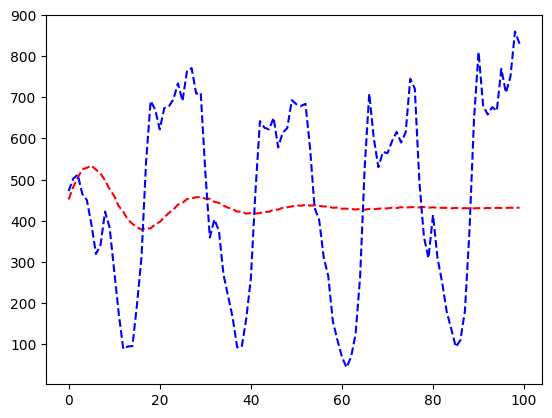

In [27]:
predict_steps = 100
# y_pred_diffs = fitted_model.predict(start=len(train_flow), end=len(train_flow) + predict_steps, dynamic=True)
y_pred_diffs = fitted_arma.forecast(100)
y_pred = [flow.iloc[len(train_flow) - 1]]
for diff in y_pred_diffs:
    y_pred.append(y_pred[-1] + diff)

y_pred = y_pred[1:]
y_pred = y_pred[:100]
y_true = flow.iloc[len(train_flow): len(train_flow)+len(y_pred)].tolist()
plt.plot(y_pred, 'r--')
plt.plot(y_true, 'b--')

In [22]:
from Scripts.auto_regression import partial_sarimax
train_flow = flow_diff.iloc[:7500]
test_flow = flow_diff.iloc[7500:]

arima = partial_sarimax((1, 0, 1), (1, 0, 1, 24))
arima = arima(train_flow)
fitted_model = arima.fit()
fitted_model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.71918D+00    |proj g|=  1.23642D-01


 This problem is unconstrained.



At iterate    5    f=  5.66512D+00    |proj g|=  1.46207D-02

At iterate   10    f=  5.61966D+00    |proj g|=  6.47305D-03

At iterate   15    f=  5.60416D+00    |proj g|=  1.08843D-02

At iterate   20    f=  5.59332D+00    |proj g|=  1.89787D-02

At iterate   25    f=  5.57584D+00    |proj g|=  1.02412D-02

At iterate   30    f=  5.56818D+00    |proj g|=  3.66515D-03

At iterate   35    f=  5.56739D+00    |proj g|=  7.40652D-03

At iterate   40    f=  5.56582D+00    |proj g|=  2.69003D-03

At iterate   45    f=  5.56574D+00    |proj g|=  6.19274D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48    112      1     0     0   3.823D-03   5.566D+00
  F =   5.5656745404112700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               flow   No. Observations:                 7500
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -41742.559
Date:                            Mon, 24 Jun 2024   AIC                          83495.118
Time:                                    17:59:06   BIC                          83529.731
Sample:                                         0   HQIC                         83507.004
                                           - 7500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8606      0.006    139.344      0.000       0.848       0.873
ma.L1         -0.9915      0.004   -247.864      0.000      -0.999      -0.984
ar.S.L24       0.9994      0.000   3290.754      0.000       0.999       1.000
ma.S.L24      -0.9431      0.003   -284.311      0.000      -0.950      -0.937
sigma2      4130.6316     38.952    106.044      0.000    4054.287    4206.976
===================================================================================
Ljung-Box (L1) (Q):                 123.44   Jarque-Bera (JB):             13614.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

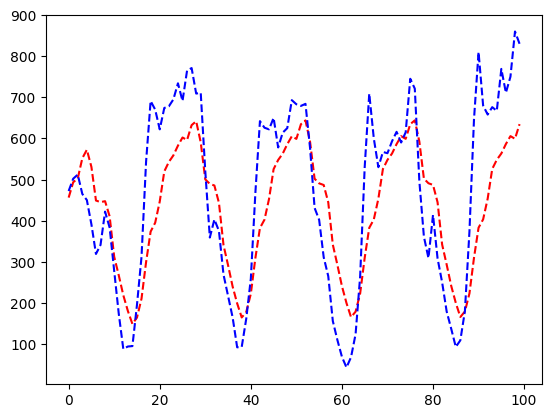

In [23]:
predict_steps = 100
# y_pred_diffs = fitted_model.predict(start=len(train_flow), end=len(train_flow) + predict_steps, dynamic=True)
y_pred_diffs = fitted_model.forecast(100)
y_pred = [flow.iloc[len(train_flow) - 1]]
for diff in y_pred_diffs:
    y_pred.append(y_pred[-1] + diff)

y_pred = y_pred[1:]
y_pred = y_pred[:100]
y_true = flow.iloc[len(train_flow): len(train_flow)+len(y_pred)].tolist()
plt.plot(y_pred, 'r--')
plt.plot(y_true, 'b--')